# Partie 5 - Modèles XGBoost Avancés

Ce notebook répond aux 3 questions de la Partie 5:

1. **Question 1**: XGBoost baseline (distance + angle)
2. **Question 2**: XGBoost optimisé avec toutes les features + hyperparameter tuning
3. **Question 3**: Sélection de features (importance, SHAP, RFE)

Pour chaque question, nous générons:
- Les 4 figures d'évaluation (ROC, Goal Rate, Cumulative, Calibration)
- Des visualisations supplémentaires pour justifier les choix
- Des métriques quantitatives comparatives

## Setup et Imports

In [1]:
import sys
from pathlib import Path

# Ajouter le root du projet au path
PROJECT_ROOT = Path.cwd().parent
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Imports des modèles
from ift6758.models.model_xgboost import (
    XGBoostModelTrainer,
    generate_evaluation_plots,
    load_and_prepare_data,
    perform_shap_analysis,
    plot_correlation_matrix,
    perform_recursive_feature_elimination
)
from ift6758.models.model_utils import (
    evaluate_model,
    print_metrics,
    plot_feature_importance,
    compare_models,
    plot_models_comparison,
    plot_learning_curves,
    plot_confusion_matrix_detailed,
    plot_threshold_analysis,
    compare_models_detailed
)

import wandb
import joblib

# Configuration matplotlib
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10
sns.set_style('whitegrid')

print("Imports completed")

Imports completed


In [2]:
# Configuration des chemins
MODELS_DIR = PROJECT_ROOT / "models_saved"
FIGURES_DIR = PROJECT_ROOT / "figures" / "milestone2"

MODELS_DIR.mkdir(parents=True, exist_ok=True)
FIGURES_DIR.mkdir(parents=True, exist_ok=True)

# Configuration Wandb
WANDB_PROJECT = "IFT6758-2025"
WANDB_ENTITY = "qi-li-1-universit-de-montr-al"

print(f"Models: {MODELS_DIR}")
print(f"Figures: {FIGURES_DIR}")
print(f"Wandb: {WANDB_ENTITY}/{WANDB_PROJECT}")

Models: /Users/qili/Library/CloudStorage/OneDrive-SanteetServicessociaux/Soins intensifs/Érudition/Recherche/MSc MedComp/IFT6758 Sciences des données/project-datascience-python/models_saved
Figures: /Users/qili/Library/CloudStorage/OneDrive-SanteetServicessociaux/Soins intensifs/Érudition/Recherche/MSc MedComp/IFT6758 Sciences des données/project-datascience-python/figures/milestone2
Wandb: qi-li-1-universit-de-montr-al/IFT6758-2025
Models: d:\Bureau\project-datascience-python\models_saved
Figures: d:\Bureau\project-datascience-python\figures\milestone2
Wandb: IFT6758-2025-A04/ift6758-milestone2


## 1. Chargement des Données

Chargement automatique des datasets train/val/test avec:
- Encodage des variables catégorielles (shot_type)
- Gestion des NaN
- Séparation X/y

In [3]:
# Charger et préparer les données
X_train, y_train, X_val, y_val, X_test, y_test = load_and_prepare_data()

# Définir les ensembles de features
BASIC_FEATURES = ["distance_net", "angle_net"]
ALL_FEATURES = list(X_train.columns)

print(f"\nFeatures baseline: {BASIC_FEATURES}")
print(f"Toutes features ({len(ALL_FEATURES)}): {ALL_FEATURES}")

Donnees chargees!
  Train: 77,226 tirs | 24 features
  Val:   19,307 tirs | Target: 9.49% buts
  Test:  57,734 tirs

Features baseline: ['distance_net', 'angle_net']
Toutes features (24): ['xCoord', 'yCoord', 'distance_net', 'angle_net', 'empty_net', 'game_seconds', 'game_period', 'prev_xCoord', 'prev_yCoord', 'delta_t', 'is_rebound', 'change_in_angle', 'shot_speed', 'distance_prev_event', 'time_since_powerplay_start', 'friendly_skaters', 'opponent_skaters', 'shot_type_backhand', 'shot_type_deflected', 'shot_type_slap', 'shot_type_snap', 'shot_type_tip-in', 'shot_type_wrap-around', 'shot_type_wrist']


In [4]:
# Analyser le déséquilibre des classes
print("="*80)
print("ANALYSE DU DESEQUILIBRE DES CLASSES")
print("="*80)

train_goal_rate = y_train.mean()
val_goal_rate = y_val.mean()
test_goal_rate = y_test.mean()

print(f"\nTaux de buts:")
print(f"  Train: {train_goal_rate:.2%} ({y_train.sum():,}/{len(y_train):,})")
print(f"  Val:   {val_goal_rate:.2%} ({y_val.sum():,}/{len(y_val):,})")
print(f"  Test:  {test_goal_rate:.2%} ({y_test.sum():,}/{len(y_test):,})")

# Calculer scale_pos_weight pour XGBoost
scale_pos_weight = (1 - train_goal_rate) / train_goal_rate
print(f"\nscale_pos_weight recommandé: {scale_pos_weight:.2f}")
print(f"  (pour compenser le déséquilibre 1:{scale_pos_weight:.1f})")

ANALYSE DU DESEQUILIBRE DES CLASSES

Taux de buts:
  Train: 9.49% (7,325/77,226)
  Val:   9.48% (1,831/19,307)
  Test:  9.76% (5,636/57,734)

scale_pos_weight recommandé: 9.54
  (pour compenser le déséquilibre 1:9.5)


---
# QUESTION 1: XGBoost Baseline (distance + angle)

## Objectif

Entraîner un XGBoost avec seulement **distance_net** et **angle_net** pour établir une baseline.

## Setup d'entraînement/validation

- **Modèle**: XGBoost avec paramètres par défaut
- **Features**: distance_net, angle_net (2 features)
- **Train**: Saisons 2016-2020 (80%)
- **Validation**: Saisons 2016-2020 (20%)
- **Test**: Saison 2020-2021 (séparé)
- **Standardisation**: StandardScaler appliqué
- **Tracking**: Wandb (projet: ift6758-milestone2)

In [5]:
# Initialiser le trainer baseline
trainer_baseline = XGBoostModelTrainer(
    project_name= WANDB_PROJECT,
    experiment_name="xgboost-baseline-distance-angle",
    wandb_entity=WANDB_ENTITY
)

print("Entraînement du modèle baseline...")
print(f"Features: {BASIC_FEATURES}")

# Entraîner
model_baseline = trainer_baseline.train_baseline(
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    features=BASIC_FEATURES,
    random_state=42
)

# Sauvegarder
trainer_baseline.save_model(
    model_path=str(MODELS_DIR / "xgboost_baseline.pkl"),
    metadata={"features": BASIC_FEATURES}
)

trainer_baseline.finish_run()

print("\nModèle baseline entraîné")

Entraînement du modèle baseline...
Features: ['distance_net', 'angle_net']


wandb: ERROR Failed to detect the name of this notebook. You can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: saliou-gueye (IFT6758-2025-A04) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Currently logged in as: saliou-gueye (IFT6758-2025-A04) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: WARNING Using a boolean value for 'reinit' is deprecated. Use 'return_previous' or 'finish_previous' instead.
wandb: WARNING Using a boolean value for 'reinit' is deprecated. Use 'return_previous' or 'finish_previous' instead.



Metrics (baseline):

  baseline/train_auc: 0.8463
  baseline/train_auc: 0.8463
  baseline/val_auc: 0.6796
  baseline/train_brier: 0.0756
  baseline/val_brier: 0.0885
  baseline/val_auc: 0.6796
  baseline/train_brier: 0.0756
  baseline/val_brier: 0.0885
Modele et scaler sauvegardes dans d:\Bureau\project-datascience-python\models_saved
Modele et scaler sauvegardes dans d:\Bureau\project-datascience-python\models_saved


baseline/train_auc,▁
baseline/train_brier,▁
baseline/val_auc,▁
baseline/val_brier,▁
baseline/train_auc,0.75206
baseline/train_brier,0.07986
baseline/val_auc,0.6997
baseline/val_brier,0.08215



Modèle baseline entraîné



Metrics (baseline):
  baseline/train_auc: 0.7521
  baseline/val_auc: 0.6997
  baseline/train_brier: 0.0799
  baseline/val_brier: 0.0822
Modele et scaler sauvegardes dans /Users/qili/Library/CloudStorage/OneDrive-SanteetServicessociaux/Soins intensifs/Érudition/Recherche/MSc MedComp/IFT6758 Sciences des données/project-datascience-python/models_saved

Metrics (baseline):
  baseline/train_auc: 0.8463
  baseline/val_auc: 0.6796
  baseline/train_brier: 0.0756
  baseline/val_brier: 0.0885
Modele et scaler sauvegardes dans d:\Bureau\project-datascience-python\models_saved


In [6]:
# Évaluer le modèle baseline
from ift6758.models.model_utils import apply_scaler

X_val_baseline = X_val[BASIC_FEATURES]
X_val_baseline_scaled = apply_scaler(X_val_baseline, trainer_baseline.scaler, fit=False)

baseline_metrics = evaluate_model(
    model_baseline,
    X_val_baseline_scaled,
    y_val,
    model_name="XGBoost Baseline (distance + angle)"
)

print_metrics(baseline_metrics)


METRIQUES: XGBoost Baseline (distance + angle)
  AUC-ROC:    0.6997
  Accuracy:   0.9051
  Precision:  0.4706
  Recall:     0.0044
  F1-Score:   0.0087


METRIQUES: XGBoost Baseline (distance + angle)
============================================================METRIQUES: XGBoost Baseline (distance + angle)
  AUC-ROC:    0.6796

  AUC-ROC:    0.6796
  Accuracy:   0.8975
  Precision:  0.0909
  Recall:     0.0039
  Accuracy:   0.8975
  Precision:  0.0909
  Recall:     0.0039
  F1-Score:   0.0075
  F1-Score:   0.0075


In [7]:
###############################################
# Upload to IFT6758 PROJECT (QILI)
###############################################
# Your project
WANDB_PROJECT = "IFT6758-2025"
WANDB_ENTITY = "qi-li-1-universit-de-montr-al"

# ---- Save model locally ----
model_path = "xgboost_baseline.pkl"
joblib.dump(model_baseline, model_path)

# ---- Start a dedicated run in YOUR project ----
run = wandb.init(
    project=WANDB_PROJECT,
    entity=WANDB_ENTITY,
    name="xgboost-baseline",
    config={"model": "XGBoost (baseline)"}
)

# ---- Log the model as an artifact ----
artifact = wandb.Artifact(
    name="xgboost_baseline",
    type="model"
)
artifact.add_file(model_path)
run.log_artifact(artifact)

# ---- Log metrics (whatever dict you have) ----
wandb.log(baseline_metrics)

run.finish()

AUC,▁
Accuracy,▁
F1,▁
Precision,▁
Recall,▁
AUC,0.6997
Accuracy,0.90511
F1,0.00866
Precision,0.47059
Recall,0.00437
model_name,XGBoost Baseline (di...


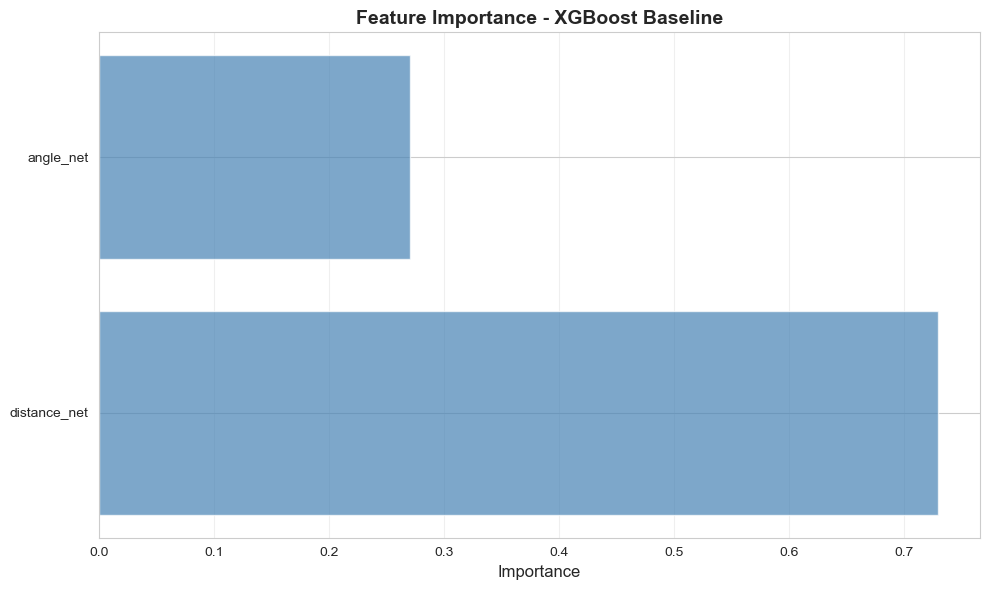

In [8]:
# Feature importance
fig = plot_feature_importance(
    model_baseline,
    BASIC_FEATURES,
    title="Feature Importance - XGBoost Baseline"
)
plt.savefig(FIGURES_DIR / "q1_feature_importance_baseline.png", dpi=150, bbox_inches='tight')
plt.show()

ANALYSE DU DESEQUILIBRE - Matrice de Confusion Baseline

ANALYSE DU DESEQUILIBRE - Matrice de Confusion Baseline

Classification Report:

Classification Report:
              precision    recall  f1-score   support

     No Goal       0.90      1.00      0.95      2330
        Goal       0.09      0.00      0.01       256

    accuracy                           0.90      2586
   macro avg       0.50      0.50      0.48      2586
weighted avg       0.82      0.90      0.85      2586

              precision    recall  f1-score   support

     No Goal       0.90      1.00      0.95      2330
        Goal       0.09      0.00      0.01       256

    accuracy                           0.90      2586
   macro avg       0.50      0.50      0.48      2586
weighted avg       0.82      0.90      0.85      2586



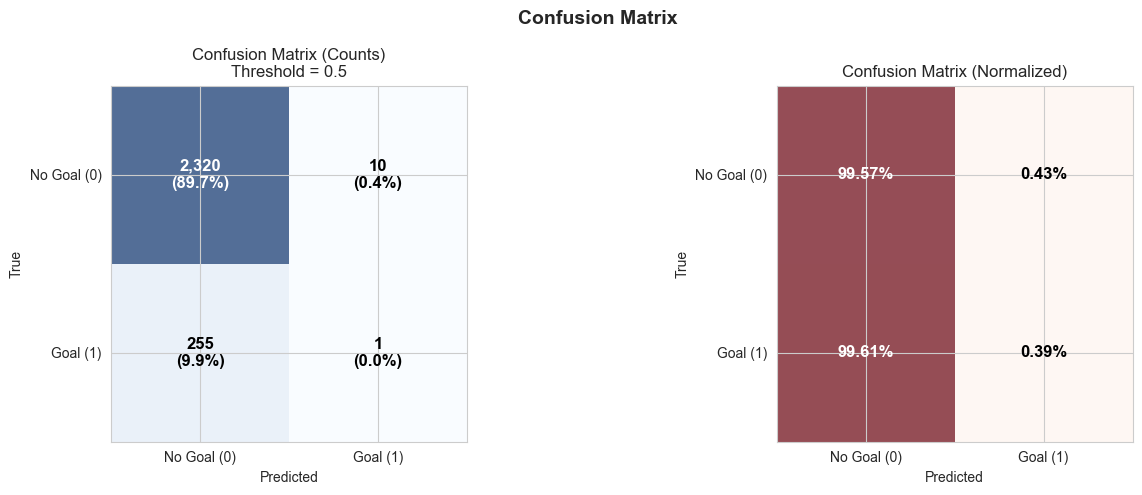


DISTRIBUTION DES PROBABILITES PREDITES


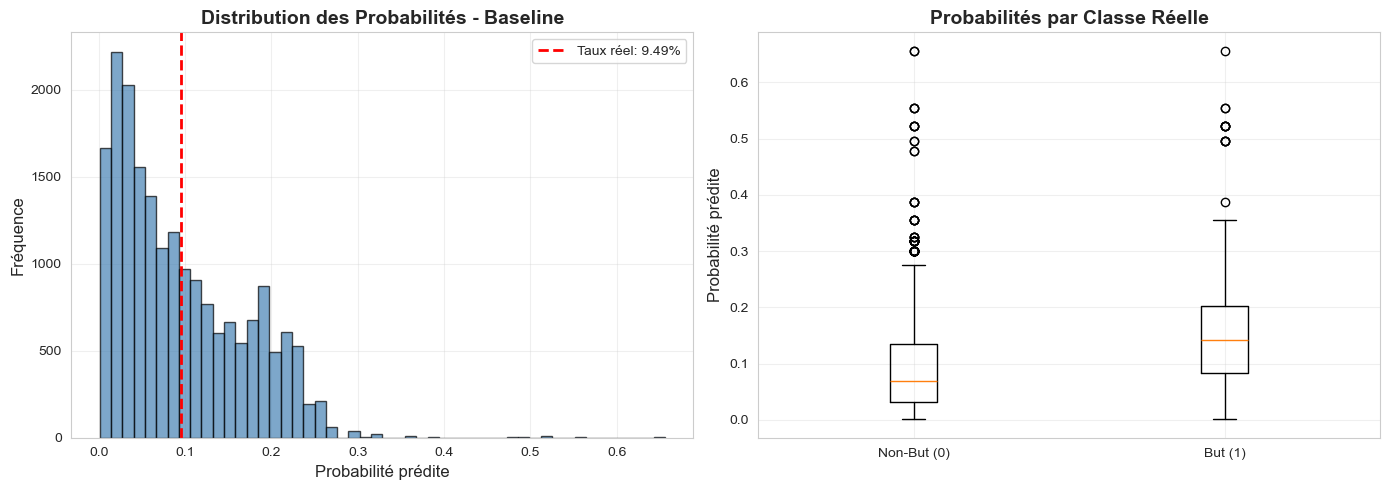


Probabilité moyenne prédite: 0.0949
Taux de buts réel: 0.0948
Écart: 0.0001

Probabilités concentrées près de 0 (<0.2): 88.79%
Probabilités bien distribuées (0.2-0.8): 11.21%

Probabilité moyenne prédite: 0.0996
Taux de buts réel: 0.0990
Écart: 0.0006

Probabilités concentrées près de 0 (<0.2): 82.87%

Taux de buts réel: 0.0990
Écart: 0.0006

Probabilités concentrées près de 0 (<0.2): 82.87%
Probabilités bien distribuées (0.2-0.8): 17.13%
Probabilités bien distribuées (0.2-0.8): 17.13%


In [9]:
# Matrice de confusion détaillée
print("="*80)
print("ANALYSE DU DESEQUILIBRE - Matrice de Confusion Baseline")
print("="*80)

y_pred_proba_baseline = model_baseline.predict_proba(X_val_baseline_scaled)[:, 1]
y_pred_baseline = (y_pred_proba_baseline >= 0.5).astype(int)

fig = plot_confusion_matrix_detailed(
    y_val,
    y_pred_baseline,
    save_path=str(FIGURES_DIR / "q1_confusion_matrix_baseline.png")
)
plt.show()

# Distribution des probabilités prédites
print("\n" + "="*80)
print("DISTRIBUTION DES PROBABILITES PREDITES")
print("="*80)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogramme
axes[0].hist(y_pred_proba_baseline, bins=50, alpha=0.7, color='steelblue', edgecolor='black')
axes[0].axvline(y_train.mean(), color='red', linestyle='--', linewidth=2, label=f'Taux réel: {y_train.mean():.2%}')
axes[0].set_xlabel('Probabilité prédite', fontsize=12)
axes[0].set_ylabel('Fréquence', fontsize=12)
axes[0].set_title('Distribution des Probabilités - Baseline', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Box plot par classe
axes[1].boxplot([y_pred_proba_baseline[y_val == 0], y_pred_proba_baseline[y_val == 1]],
                labels=['Non-But (0)', 'But (1)'])
axes[1].set_ylabel('Probabilité prédite', fontsize=12)
axes[1].set_title('Probabilités par Classe Réelle', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(FIGURES_DIR / "q1_probability_distribution_baseline.png", dpi=150, bbox_inches='tight')
plt.show()

# Statistiques
print(f"\nProbabilité moyenne prédite: {y_pred_proba_baseline.mean():.4f}")
print(f"Taux de buts réel: {y_val.mean():.4f}")
print(f"Écart: {abs(y_pred_proba_baseline.mean() - y_val.mean()):.4f}")
print(f"\nProbabilités concentrées près de 0 (<0.2): {(y_pred_proba_baseline < 0.2).sum() / len(y_pred_proba_baseline):.2%}")
print(f"Probabilités bien distribuées (0.2-0.8): {((y_pred_proba_baseline >= 0.2) & (y_pred_proba_baseline <= 0.8)).sum() / len(y_pred_proba_baseline):.2%}")

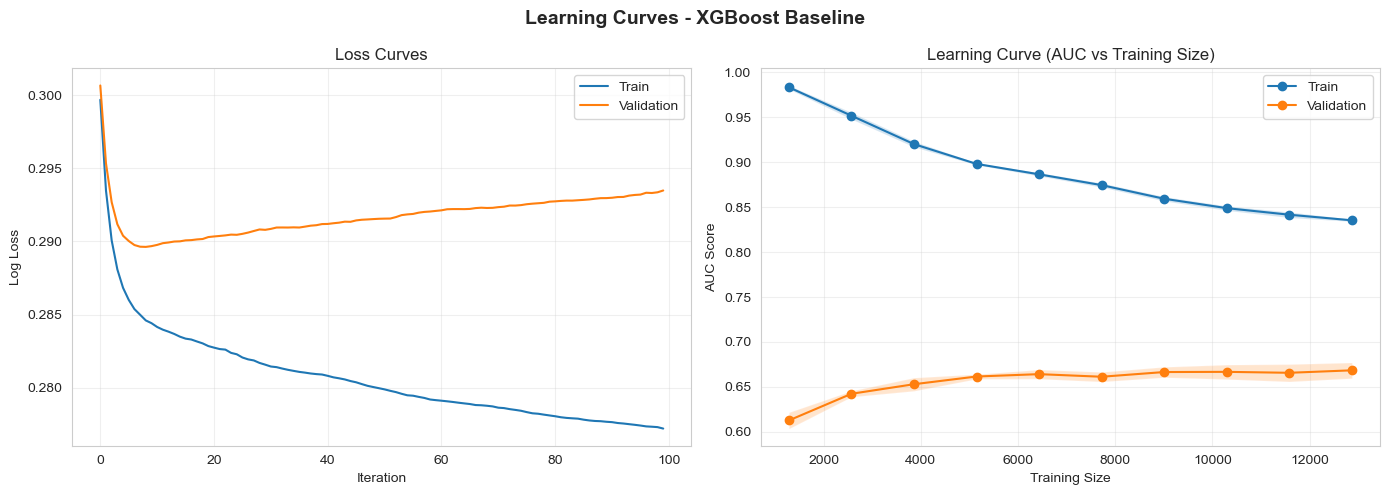

In [10]:
# Learning curves
fig = plot_learning_curves(
    model_baseline,
    X_val_baseline_scaled,
    y_val,
    X_val_baseline_scaled,
    y_val,
    title="Learning Curves - XGBoost Baseline",
    save_path=str(FIGURES_DIR / "q1_learning_curves_baseline.png")
)
plt.show()

---
# QUESTION 2: XGBoost Optimisé (toutes features + tuning)

## Objectif

Utiliser **toutes les features** et optimiser les hyperparamètres pour maximiser les performances.

## Configuration de tuning

- **Méthode**: RandomizedSearchCV (100 essais)
- **Cross-validation**: 5-fold
- **Métrique d'optimisation**: ROC AUC
- **Hyperparamètres**:
  - max_depth: [3, 5, 7]
  - learning_rate: [0.01, 0.05, 0.1]
  - n_estimators: [100, 200, 300]
  - min_child_weight: [1, 3, 5]
  - subsample: [0.7,0.8, 0.9, 1.0]
  - colsample_bytree: [0.8, 0.9, 1.0]
  - scale_pos_weight: [scale_pos_weight, scale_pos_weight x 0.5, scale_pos_weight x 0.75]

In [11]:
# Définir la grille de paramètres
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 300],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'scale_pos_weight': [scale_pos_weight, scale_pos_weight*0.5, scale_pos_weight*0.75]
}

total_combinations = np.prod([len(v) for v in param_grid.values()])
print(f"Espace de recherche: {total_combinations:,} combinaisons")
print(f"Méthode: RandomizedSearchCV (100 essais avec 5-fold CV)")

Espace de recherche: 2,916 combinaisons
Méthode: RandomizedSearchCV (100 essais avec 5-fold CV)


In [12]:
# Entraîner avec tuning
import time
start_time = time.time()

trainer_tuned = XGBoostModelTrainer(
    project_name=WANDB_PROJECT,
    experiment_name="xgboost-tuned-all-features",
    wandb_entity=WANDB_ENTITY,
)

print("Lancement de l'optimisation des hyperparamètres...")

model_tuned = trainer_tuned.train_with_all_features(
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    param_grid=param_grid,
    search_type="random",
    cv=5,
    n_iter=100,
    random_state=42
)

elapsed_time = time.time() - start_time
print(f"\nTemps d'exécution: {elapsed_time/60:.1f} minutes")

Lancement de l'optimisation des hyperparamètres...



Lancement de l'optimisation des hyperparamètres...


Starting random search with 5-fold CV...

Metrics (tuned):
  tuned/train_auc: 0.8064
  tuned/val_auc: 0.7601
  tuned/train_brier: 0.1168
  tuned/val_brier: 0.1232

Temps d'exécution: 1.7 minutes


Starting random search with 5-fold CV...


Metrics (tuned):
  tuned/train_auc: 0.7864
Metrics (tuned):
  tuned/train_auc: 0.7864
  tuned/val_auc: 0.7431
  tuned/val_auc: 0.7431
  tuned/train_brier: 0.1221
  tuned/val_brier: 0.1294

  tuned/train_brier: 0.1221
  tuned/val_brier: 0.1294

Temps d'exécution: 3.1 minutes

Temps d'exécution: 3.1 minutes


In [13]:
# Afficher les meilleurs hyperparamètres
best_params = model_tuned.get_params()
print("\nMEILLEURS HYPERPARAMETRES:")
print("="*60)
for param in ['max_depth', 'learning_rate', 'n_estimators', 
              'min_child_weight', 'subsample', 'colsample_bytree', 
              'scale_pos_weight']:
    if param in best_params:
        print(f"  {param:20s}: {best_params[param]}")


MEILLEURS HYPERPARAMETRES:
  max_depth           : 3

  max_depth           : 3
  learning_rate       : 0.05
  n_estimators        : 100
  min_child_weight    : 3
  subsample           : 0.8
  colsample_bytree    : 1.0
  scale_pos_weight    : 4.55078125  learning_rate       : 0.05
  n_estimators        : 100
  min_child_weight    : 3
  subsample           : 0.8
  colsample_bytree    : 1.0
  scale_pos_weight    : 4.55078125



In [33]:
###############################################
# Upload to IFT6758 PROJECT (QILI)
###############################################
# project
WANDB_PROJECT = "IFT6758-2025"
WANDB_ENTITY = "qi-li-1-universit-de-montr-al"

# ---- Save model locally ----
model_path = "xgboost_tuned.pkl"
joblib.dump(model_tuned, model_path)

# ---- Start a dedicated run in YOUR project ----
run = wandb.init(
    project=WANDB_PROJECT,
    entity=WANDB_ENTITY,
    name="xgboost-tuned-all-features",
    config={"model": "XGBoost (tuned with all features)"}
)

# ---- Log the model as an artifact ----
artifact = wandb.Artifact(
    name="xgboost_tuned_w_all_features",
    type="model"
)
artifact.add_file(model_path)
run.log_artifact(artifact)

# ---- Log metrics (whatever dict you have) ----
wandb.log(baseline_metrics)

run.finish()

AUC,▁
Accuracy,▁
F1,▁
Precision,▁
Recall,▁
AUC,0.6997
Accuracy,0.90511
F1,0.00866
Precision,0.47059
Recall,0.00437
model_name,XGBoost Baseline (di...


In [14]:
# Sauvegarder
trainer_tuned.save_model(
    model_path=str(MODELS_DIR / "xgboost_tuned.pkl"),
    metadata={"features": ALL_FEATURES, "best_params": best_params}
)

trainer_tuned.finish_run()

print("\nModèle optimisé sauvegardé")

Modele et scaler sauvegardes dans d:\Bureau\project-datascience-python\models_saved



best_cv_score,▁
tuned/train_auc,▁
tuned/train_brier,▁
tuned/val_auc,▁
tuned/val_brier,▁
best_cv_score,0.75985
tuned/train_auc,0.80638
tuned/train_brier,0.11678
tuned/val_auc,0.7601
tuned/val_brier,0.12323



Modèle optimisé sauvegardé
Modele et scaler sauvegardes dans /Users/qili/Library/CloudStorage/OneDrive-SanteetServicessociaux/Soins intensifs/Érudition/Recherche/MSc MedComp/IFT6758 Sciences des données/project-datascience-python/models_saved


In [15]:
# Évaluer le modèle optimisé
X_val_scaled = apply_scaler(X_val, trainer_tuned.scaler, fit=False)

tuned_metrics = evaluate_model(
    model_tuned,
    X_val_scaled,
    y_val,
    model_name="XGBoost Tuned (all features)"
)

print_metrics(tuned_metrics)

# Comparer avec baseline
improvement_auc = (tuned_metrics['AUC'] - baseline_metrics['AUC']) / baseline_metrics['AUC'] * 100
print(f"\nAmélioration AUC vs Baseline: {improvement_auc:+.2f}%")


METRIQUES: XGBoost Tuned (all features)
  AUC-ROC:    0.7601
  Accuracy:   0.8337
  Precision:  0.2570
  Recall:     0.3981
  F1-Score:   0.3123

Amélioration AUC vs Baseline: +8.63%


METRIQUES: XGBoost Tuned (all features)
  AUC-ROC:    0.7431
METRIQUES: XGBoost Tuned (all features)
  AUC-ROC:    0.7431
  Accuracy:   0.8353
  Precision:  0.2515  Accuracy:   0.8353
  Precision:  0.2515
  Recall:     0.3359
  F1-Score:   0.2876

Amélioration AUC vs Baseline: +9.34%

  Recall:     0.3359
  F1-Score:   0.2876

Amélioration AUC vs Baseline: +9.34%


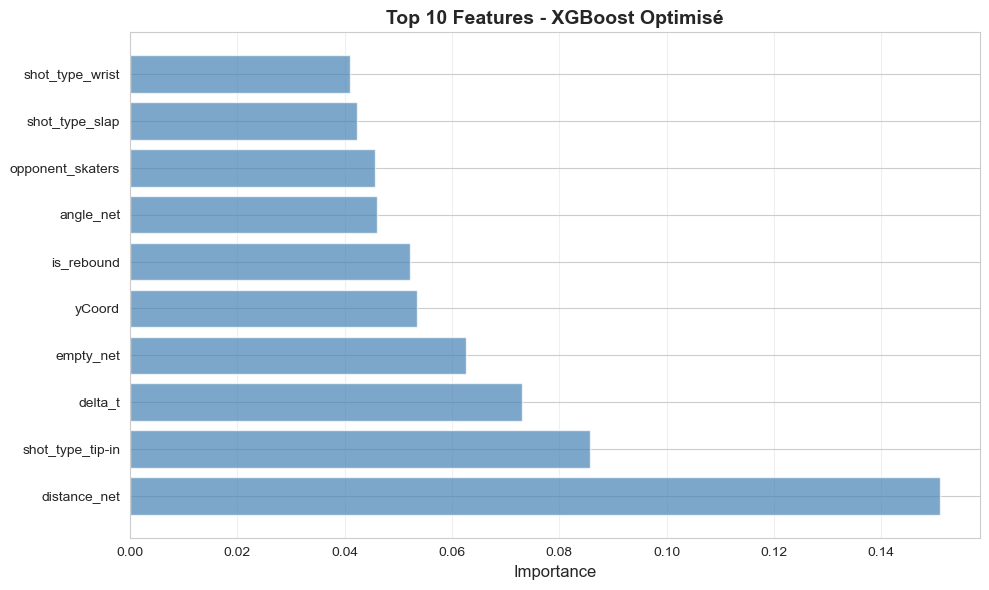

In [16]:
# Feature importance
fig = plot_feature_importance(
    model_tuned,
    ALL_FEATURES,
    title="Top 10 Features - XGBoost Optimisé",
    top_n=10
)
plt.savefig(FIGURES_DIR / "q2_feature_importance_tuned.png", dpi=150, bbox_inches='tight')
plt.show()


 Optimal Threshold: 0.4800
  Precision: 0.2487
  Recall:    0.4457
  F1-Score:  0.3192


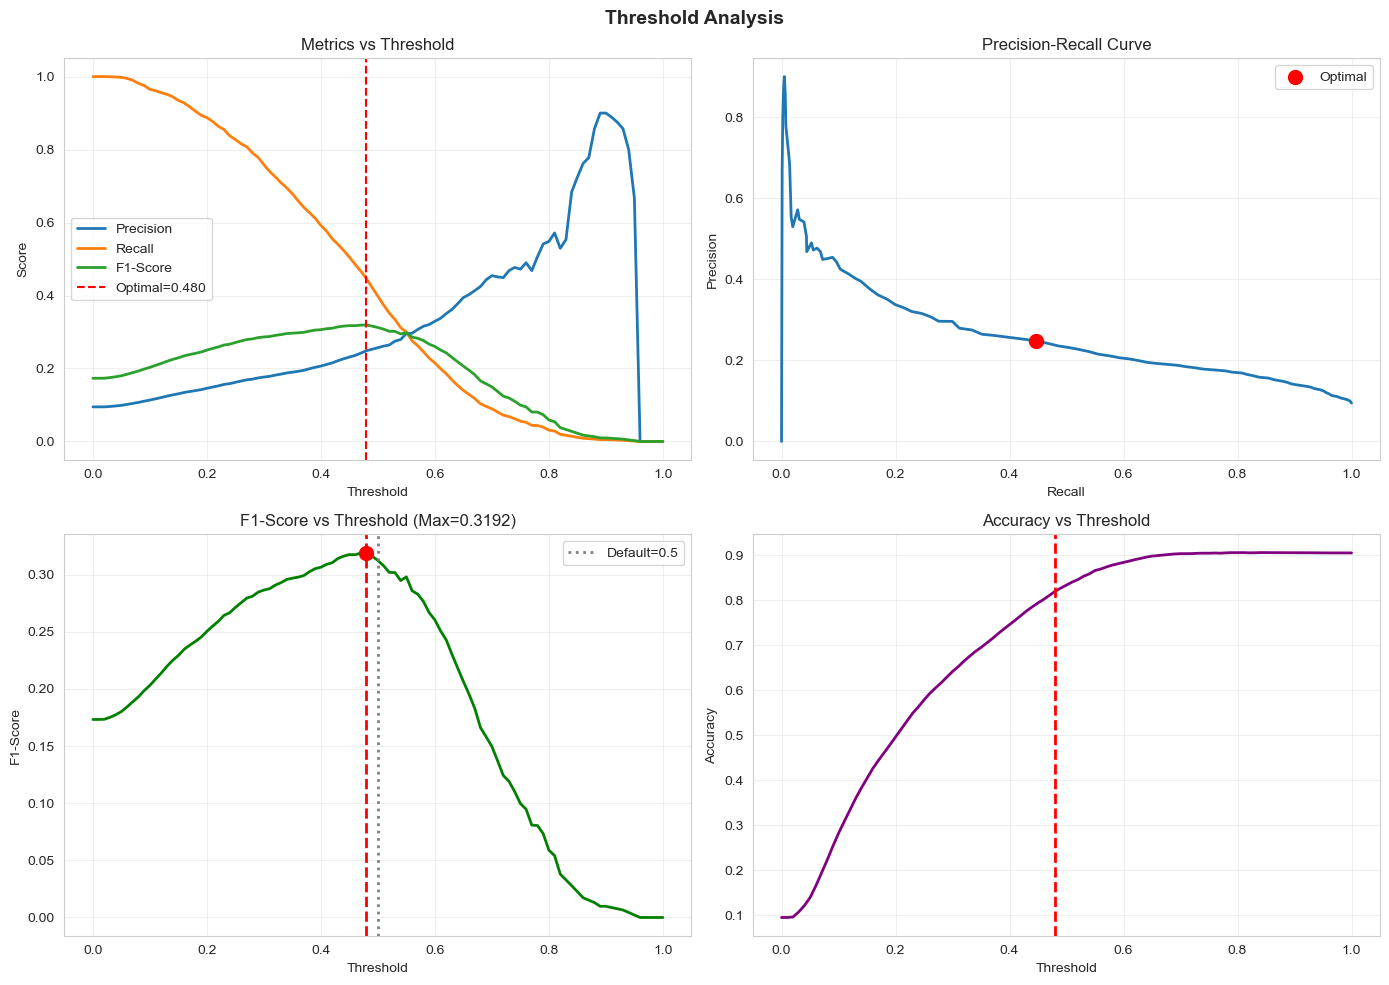


 Optimal Threshold: 0.4300

  Precision: 0.2127
  Recall:    0.5117
  F1-Score:  0.3005  Precision: 0.2127
  Recall:    0.5117
  F1-Score:  0.3005



In [17]:
# Analyse du seuil de décision
y_pred_proba_tuned = model_tuned.predict_proba(X_val_scaled)[:, 1]

fig, optimal_threshold = plot_threshold_analysis(
    y_val,
    y_pred_proba_tuned,
    save_path=str(FIGURES_DIR / "q2_threshold_analysis.png")
)
plt.show()

ANALYSE DU DESEQUILIBRE - Matrice de Confusion Optimisée

ANALYSE DU DESEQUILIBRE - Matrice de Confusion Optimisée

Classification Report:

Classification Report:
              precision    recall  f1-score   support

     No Goal       0.92      0.89      0.91      2330
        Goal       0.25      0.34      0.29       256

    accuracy                           0.84      2586
   macro avg       0.59      0.61      0.60      2586
weighted avg       0.86      0.84      0.85      2586
              precision    recall  f1-score   support

     No Goal       0.92      0.89      0.91      2330
        Goal       0.25      0.34      0.29       256

    accuracy                           0.84      2586
   macro avg       0.59      0.61      0.60      2586
weighted avg       0.86      0.84      0.85      2586




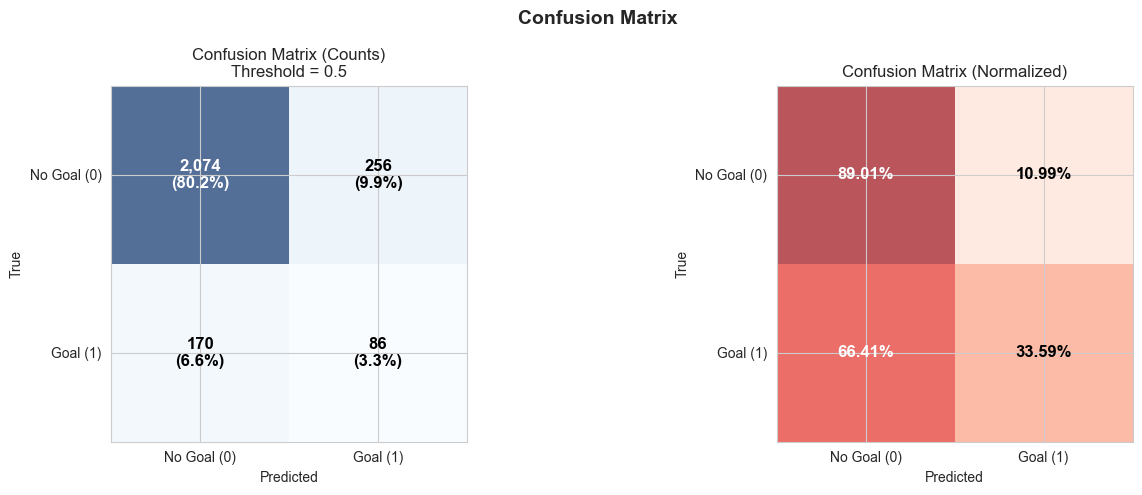


DISTRIBUTION DES PROBABILITES - MODELE OPTIMISE


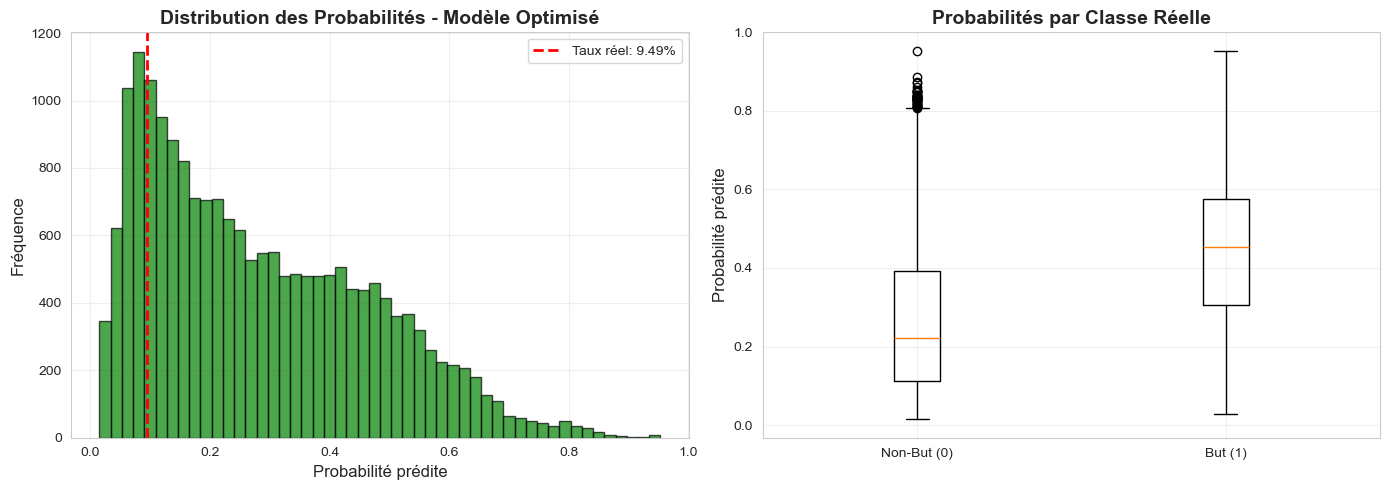


Probabilité moyenne prédite: 0.2802
Taux de buts réel: 0.0948
Écart: 0.1854

Probabilités concentrées près de 0 (<0.2): 42.25%
Probabilités bien distribuées (0.2-0.8): 57.21%

ANALYSE DU SEUIL:
Seuil optimal trouvé: 0.4800
  Le seuil optimal < 0.5 indique un bon ajustement au déséquilibre
  Le modèle compense correctement la rareté des buts

Probabilité moyenne prédite: 0.2944
Taux de buts réel: 0.0990
Écart: 0.1954

Probabilités concentrées près de 0 (<0.2): 37.12%
Probabilités bien distribuées (0.2-0.8): 62.88%

ANALYSE DU SEUIL:
Seuil optimal trouvé: 0.4300
  Le seuil optimal < 0.5 indique un bon ajustement au déséquilibre
  Le modèle compense correctement la rareté des buts


In [18]:
# Matrice de confusion - Modèle Optimisé
print("="*80)
print("ANALYSE DU DESEQUILIBRE - Matrice de Confusion Optimisée")
print("="*80)

y_pred_tuned = (y_pred_proba_tuned >= 0.5).astype(int)

fig = plot_confusion_matrix_detailed(
    y_val,
    y_pred_tuned,
    save_path=str(FIGURES_DIR / "q2_confusion_matrix_tuned.png")
)
plt.show()

# Distribution des probabilités - Modèle Optimisé
print("\n" + "="*80)
print("DISTRIBUTION DES PROBABILITES - MODELE OPTIMISE")
print("="*80)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogramme
axes[0].hist(y_pred_proba_tuned, bins=50, alpha=0.7, color='green', edgecolor='black')
axes[0].axvline(y_train.mean(), color='red', linestyle='--', linewidth=2, label=f'Taux réel: {y_train.mean():.2%}')
axes[0].set_xlabel('Probabilité prédite', fontsize=12)
axes[0].set_ylabel('Fréquence', fontsize=12)
axes[0].set_title('Distribution des Probabilités - Modèle Optimisé', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Box plot par classe
axes[1].boxplot([y_pred_proba_tuned[y_val == 0], y_pred_proba_tuned[y_val == 1]],
                labels=['Non-But (0)', 'But (1)'])
axes[1].set_ylabel('Probabilité prédite', fontsize=12)
axes[1].set_title('Probabilités par Classe Réelle', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(FIGURES_DIR / "q2_probability_distribution_tuned.png", dpi=150, bbox_inches='tight')
plt.show()

# Statistiques comparatives
print(f"\nProbabilité moyenne prédite: {y_pred_proba_tuned.mean():.4f}")
print(f"Taux de buts réel: {y_val.mean():.4f}")
print(f"Écart: {abs(y_pred_proba_tuned.mean() - y_val.mean()):.4f}")
print(f"\nProbabilités concentrées près de 0 (<0.2): {(y_pred_proba_tuned < 0.2).sum() / len(y_pred_proba_tuned):.2%}")
print(f"Probabilités bien distribuées (0.2-0.8): {((y_pred_proba_tuned >= 0.2) & (y_pred_proba_tuned <= 0.8)).sum() / len(y_pred_proba_tuned):.2%}")

# Analyse du seuil optimal vs 0.5
print(f"\nANALYSE DU SEUIL:")
print(f"Seuil optimal trouvé: {optimal_threshold:.4f}")
if optimal_threshold < 0.5:
    print(f"  Le seuil optimal < 0.5 indique un bon ajustement au déséquilibre")
    print(f"  Le modèle compense correctement la rareté des buts")
else:
    print(f"  Le seuil optimal >= 0.5 suggère un ajustement potentiellement insuffisant")

---
# QUESTION 3: Sélection de Features

## Objectif

Explorer différentes techniques de sélection de features pour:
1. Simplifier le modèle
2. Réduire la redondance
3. Améliorer l'interprétabilité

## Techniques explorées

1. **Feature Importance** (XGBoost natif)
2. **SHAP values** (interprétabilité)
3. **Recursive Feature Elimination (RFE)**
4. **Correlation Matrix** (redondance)

## 3.1. Analyse de corrélation


 Features fortement corrélées (|r| >= 0.7):
   - game_seconds <-> game_period: r = 0.946
   - is_rebound <-> change_in_angle: r = 0.747
   - time_since_powerplay_start <-> opponent_skaters: r = -0.779

  Considérer la suppression d'une des features dans chaque paire


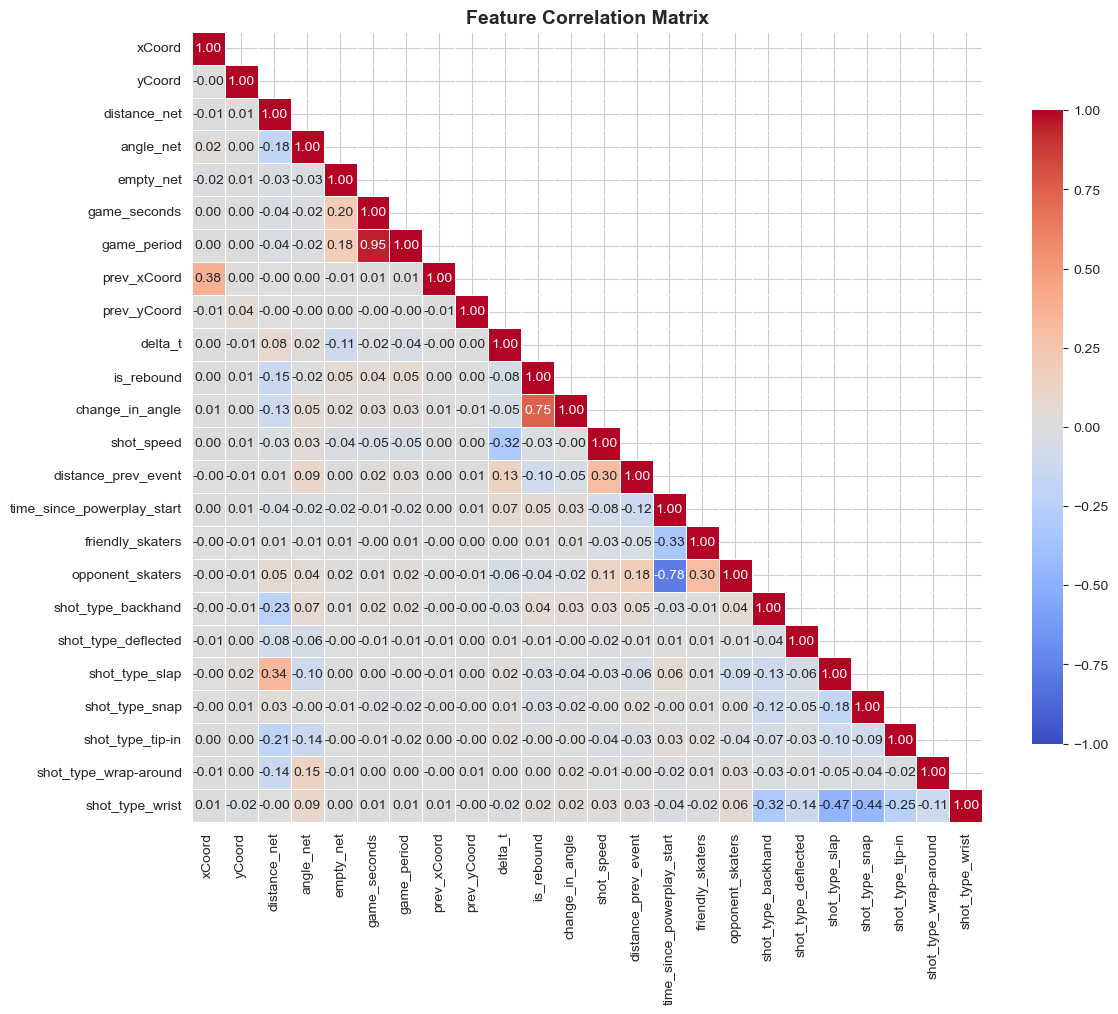


 Features fortement corrélées (|r| >= 0.7):

   - game_seconds <-> game_period: r = 0.947
   - game_seconds <-> game_period: r = 0.947
   - is_rebound <-> change_in_angle: r = 0.739
   - time_since_powerplay_start <-> opponent_skaters: r = -0.797   - is_rebound <-> change_in_angle: r = 0.739
   - time_since_powerplay_start <-> opponent_skaters: r = -0.797

  Considérer la suppression d'une des features dans chaque paire


  Considérer la suppression d'une des features dans chaque paire


In [19]:
# Matrice de corrélation
fig = plot_correlation_matrix(
    X_train,
    threshold=0.7,
    output_path=str(FIGURES_DIR / "q3_correlation_matrix.png")
)
plt.show()

## 3.2. SHAP Analysis

In [20]:
# Analyse SHAP complète
shap_results = perform_shap_analysis(
    model_tuned,
    X_val_scaled,
    max_display=15,
    sample_size=1000,
    output_dir=str(FIGURES_DIR)
)

SHAP n'est pas installé. Installation: pip install shap
Calcul des SHAP values sur 1000 échantillons...

Initialisation de l'explainer SHAP...
Initialisation de l'explainer SHAP...


  0%|          | 0/1000 [00:00<?, ?it/s]


 Generating SHAP Summary Plot (bar)...
Generating SHAP Summary Plot (beeswarm)...
Generating SHAP Dependence Plots...
Generating SHAP Waterfall Plot...
Generating SHAP Force Plot...

 SHAP analysis complete!
  Figures saved to d:\Bureau\project-datascience-python\figures\milestone2


## 3.3. Recursive Feature Elimination (RFE)

In [21]:
# RFE avec cross-validation
import xgboost as xgb

selected_features_rfe, fig_rfe = perform_recursive_feature_elimination(
    model_class=xgb.XGBClassifier,
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    n_features_to_select=10,
    step=1,
    cv=3,
    random_state=42,
    eval_metric='logloss'
)

plt.savefig(FIGURES_DIR / "q3_rfe_analysis.png", dpi=150, bbox_inches='tight')
plt.show()


RFE: Sélection de 10 features parmi 23...

 RFE completed
  Optimal number of features: 11 RFE completed
  Optimal number of features: 11
  Selected features: ['distance_net', 'angle_net', 'game_seconds', 'prev_xCoord', 'delta_t', 'change_in_angle', 'shot_speed', 'time_since_powerplay_start', 'opponent_skaters', 'shot_type_slap', 'shot_type_snap']
  Selected features: ['distance_net', 'angle_net', 'game_seconds', 'prev_xCoord', 'delta_t', 'change_in_angle', 'shot_speed', 'time_since_powerplay_start', 'opponent_skaters', 'shot_type_slap', 'shot_type_snap']




COMPARAISON DES MÉTHODES DE SÉLECTION DE FEATURES
COMPARAISON DES MÉTHODES DE SÉLECTION DE FEATURES

 MÉTHODE EMBARQUÉE: Feature Importance XGBoost


 MÉTHODE EMBARQUÉE: Feature Importance XGBoost

 MÉTHODE STATISTIQUE: Mutual Information

 MÉTHODE STATISTIQUE: Mutual Information

Sélection statistique (mutual_info): 10 features...

Sélection statistique (mutual_info): 10 features...
✓ Sélection complétée
  Features sélectionnées: ['xCoord', 'yCoord', 'distance_net', 'angle_net', 'empty_net', 'game_period', 'prev_yCoord', 'delta_t', 'shot_speed', 'distance_prev_event']
✓ Sélection complétée
  Features sélectionnées: ['xCoord', 'yCoord', 'distance_net', 'angle_net', 'empty_net', 'game_period', 'prev_yCoord', 'delta_t', 'shot_speed', 'distance_prev_event']

 MÉTHODE WRAPPER: Recursive Feature Elimination

RFE: Sélection de 10 features parmi 23...

 MÉTHODE WRAPPER: Recursive Feature Elimination

RFE: Sélection de 10 features parmi 23...
 RFE completed
  Optimal number of features: 8
  S

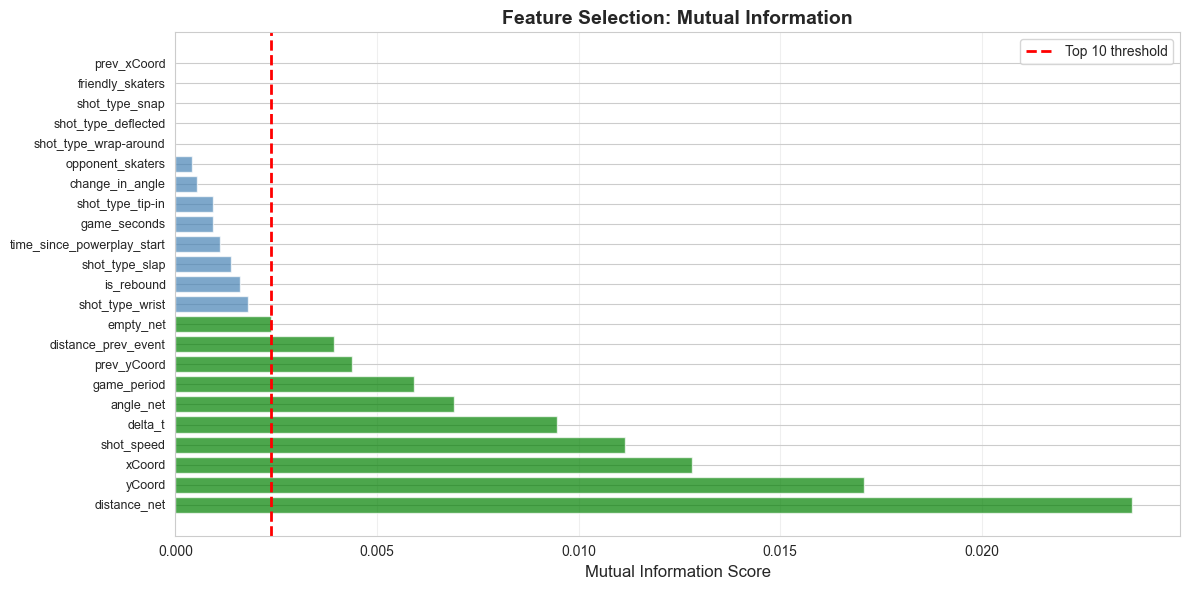

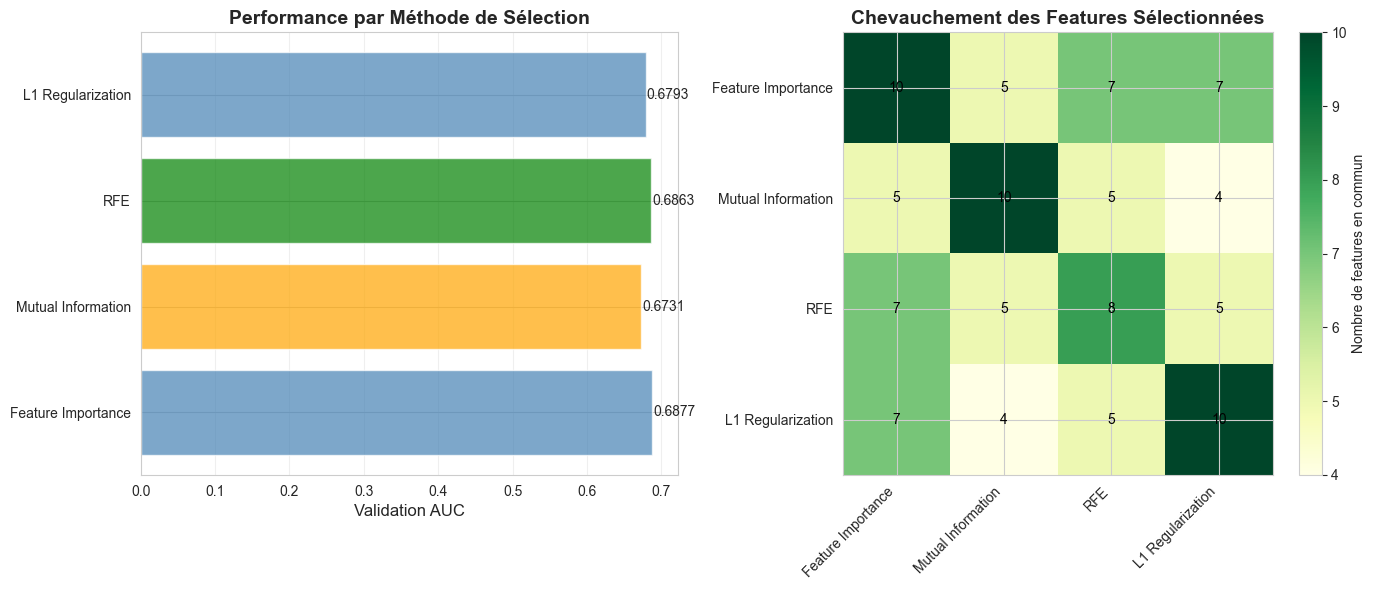


Méthode                   Type            AUC        Features
--------------------------------------------------------------------------------
Feature Importance        Embarquée       0.6877     10
Mutual Information        Statistique     0.6731     10
RFE                       Wrapper         0.6863     8
L1 Regularization         Embarquée       0.6793     10

 Features communes à TOUTES les méthodes (2):
  - distance_net
  - angle_net

 RECOMMANDATION: 'Feature Importance' (AUC = 0.6877)

ANALYSE COMPARATIVE DES MÉTHODES

Feature Importance (Embarquée):
  AUC: 0.6877
  Features: distance_net, shot_type_wrap-around, shot_type_snap...

Mutual Information (Statistique):
  AUC: 0.6731
  Features: xCoord, yCoord, distance_net...

RFE (Wrapper):
  AUC: 0.6863
  Features: yCoord, distance_net, angle_net...

L1 Regularization (Embarquée):
  AUC: 0.6793
  Features: distance_net, angle_net, game_seconds...


In [22]:
# Comparaison de toutes les méthodes
from ift6758.models.model_xgboost import compare_feature_selection_methods

comparison_results = compare_feature_selection_methods(
    xgb.XGBClassifier,
    X_train, y_train, X_val, y_val,
    n_features=10,
    output_dir=str(FIGURES_DIR),
    random_state=42,
    scale_pos_weight=scale_pos_weight
)

# Afficher les résultats détaillés
print("\n" + "="*80)
print("ANALYSE COMPARATIVE DES MÉTHODES")
print("="*80)

for method_name, results in comparison_results.items():
    print(f"\n{method_name} ({results['method_type']}):")
    print(f"  AUC: {results['auc']:.4f}")
    print(f"  Features: {', '.join(results['features'][:3])}...")  # Top 3

In [23]:
# Sélection avec régularisation L1 (méthode embarquée)
from ift6758.models.model_xgboost import perform_l1_regularization_selection

selected_features_l1, fig_l1 = perform_l1_regularization_selection(
    X_train, y_train, X_val, y_val,
    n_features_to_select=10,
    output_path=str(FIGURES_DIR / "q3_l1_regularization.png")
)

print(f"\n{len(selected_features_l1)} features sélectionnées par L1 Regularization:")
for feat in selected_features_l1[:5]:
    print(f"  - {feat}")


L1 Regularization Selection: 10 features...

  L1 Selection completed
  Optimal C: 0.0212
  L1 Selection completed
  Optimal C: 0.0212
  Features sélectionnées (10): ['distance_net', 'angle_net', 'game_seconds', 'is_rebound', 'shot_speed', 'distance_prev_event', 'opponent_skaters', 'shot_type_slap', 'shot_type_snap', 'shot_type_wrap-around']
  Features sélectionnées (10): ['distance_net', 'angle_net', 'game_seconds', 'is_rebound', 'shot_speed', 'distance_prev_event', 'opponent_skaters', 'shot_type_slap', 'shot_type_snap', 'shot_type_wrap-around']

10 features sélectionnées par L1 Regularization:

10 features sélectionnées par L1 Regularization:
  - distance_net
  - angle_net  - distance_net
  - angle_net
  - game_seconds
  - is_rebound
  - shot_speed

  - game_seconds
  - is_rebound
  - shot_speed


#### L1 Regularization (Embedded)


Sequential Feature Selection (forward): 10 features...
SFS completed
Selected features: ['yCoord', 'distance_net', 'empty_net', 'game_seconds', 'game_period', 'prev_yCoord', 'delta_t', 'time_since_powerplay_start', 'shot_type_backhand', 'shot_type_slap']

10 features sélectionnées par Sequential FS:
  - yCoord
  - distance_net
  - empty_net
  - game_seconds
  - game_period


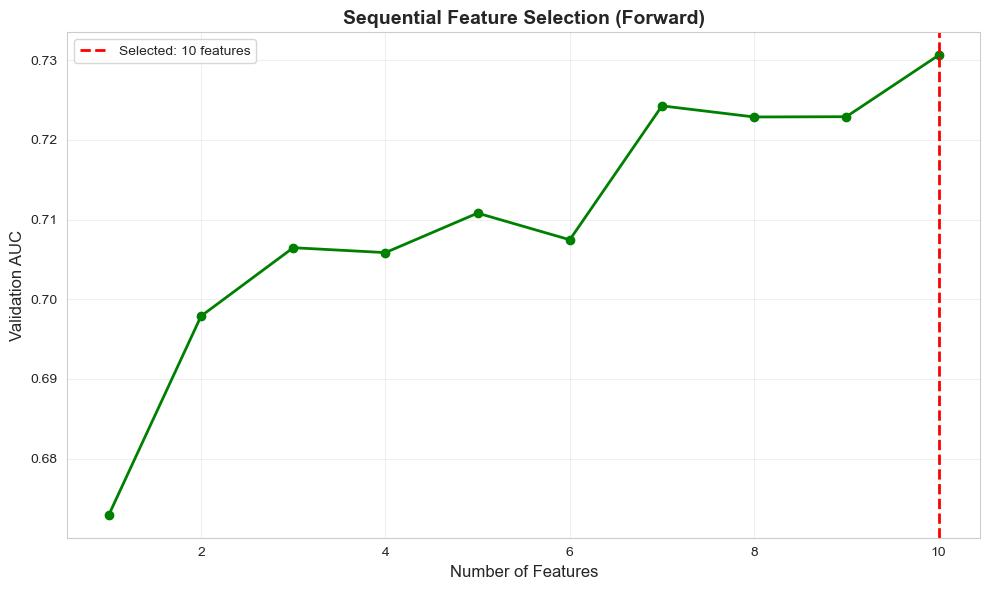


Sequential Feature Selection (forward): 10 features...

SFS completed
SFS completed
Selected features: ['yCoord', 'distance_net', 'angle_net', 'empty_net', 'game_seconds', 'prev_yCoord', 'delta_t', 'is_rebound', 'shot_type_snap', 'shot_type_wrap-around']
Selected features: ['yCoord', 'distance_net', 'angle_net', 'empty_net', 'game_seconds', 'prev_yCoord', 'delta_t', 'is_rebound', 'shot_type_snap', 'shot_type_wrap-around']

10 features sélectionnées par Sequential FS:
  - yCoord

10 features sélectionnées par Sequential FS:
  - yCoord
  - distance_net
  - angle_net  - distance_net
  - angle_net
  - empty_net
  - game_seconds

  - empty_net
  - game_seconds


In [24]:
# Sélection séquentielle forward (méthode wrapper)
from ift6758.models.model_xgboost import perform_sequential_feature_selection

selected_features_seq, fig_seq = perform_sequential_feature_selection(
    xgb.XGBClassifier,
    X_train, y_train, X_val, y_val,
    n_features_to_select=10,
    direction="forward",
    output_path=str(FIGURES_DIR / "q3_sequential_forward.png"),
    random_state=42,
    scale_pos_weight=scale_pos_weight
)

print(f"\n{len(selected_features_seq)} features sélectionnées par Sequential FS:")
for feat in selected_features_seq[:5]:
    print(f"  - {feat}")

#### Sequential Feature Selection (Wrapper)

In [24]:
# Sélection avec Mutual Information (méthode statistique)
from ift6758.models.model_xgboost import perform_statistical_feature_selection

selected_features_mi, fig_mi = perform_statistical_feature_selection(
    X_train, y_train, 
    n_features_to_select=10,
    method="mutual_info",
    output_path=str(FIGURES_DIR / "q3_statistical_mutual_info.png")
)

print(f"\n{len(selected_features_mi)} features sélectionnées par Mutual Information:")
for feat in selected_features_mi[:5]:
    print(f"  - {feat}")


Sélection statistique (mutual_info): 10 features...

✓ Sélection complétée
✓ Sélection complétée
  Features sélectionnées: ['xCoord', 'yCoord', 'distance_net', 'angle_net', 'game_seconds', 'delta_t', 'is_rebound', 'shot_speed', 'friendly_skaters', 'shot_type_wrap-around']
  Features sélectionnées: ['xCoord', 'yCoord', 'distance_net', 'angle_net', 'game_seconds', 'delta_t', 'is_rebound', 'shot_speed', 'friendly_skaters', 'shot_type_wrap-around']

10 features sélectionnées par Mutual Information:

10 features sélectionnées par Mutual Information:
  - xCoord  - xCoord
  - yCoord
  - yCoord
  - distance_net
  - angle_net
  - game_seconds

  - distance_net
  - angle_net
  - game_seconds


## 3.4 Sélection par Feature Importance

In [25]:
# Sélection par importance (méthode utilisée)
trainer_fs = XGBoostModelTrainer(
    project_name=WANDB_PROJECT,
    experiment_name="xgboost-feature-selection",
    wandb_entity=WANDB_ENTITY
)

model_fs, selected_features = trainer_fs.train_with_feature_selection(
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    selection_method="importance",
    n_features_to_select=10,
    best_params=best_params,
    random_state=42
)

trainer_fs.save_model(
    model_path=str(MODELS_DIR / "xgboost_feature_selected.pkl"),
    metadata={"features": selected_features}
)

trainer_fs.finish_run()

print(f"\nFeatures sélectionnées ({len(selected_features)}):")
for i, feat in enumerate(selected_features, 1):
    print(f"  {i:2d}. {feat}")


Metrics (feature_selected):
  feature_selected/train_auc: 0.7766
  feature_selected/train_auc: 0.7766
  feature_selected/val_auc: 0.7401
  feature_selected/train_brier: 0.1243

  feature_selected/val_auc: 0.7401
  feature_selected/train_brier: 0.1243
  feature_selected/val_brier: 0.1311
  feature_selected/val_brier: 0.1311
Modele et scaler sauvegardes dans d:\Bureau\project-datascience-python\models_saved
Modele et scaler sauvegardes dans d:\Bureau\project-datascience-python\models_saved


feature_selected/train_auc,▁
feature_selected/train_brier,▁
feature_selected/val_auc,▁
feature_selected/val_brier,▁
feature_selected/train_auc,0.77805
feature_selected/train_brier,0.12302
feature_selected/val_auc,0.74519
feature_selected/val_brier,0.12712



Metrics (feature_selected):
  feature_selected/train_auc: 0.7781
  feature_selected/val_auc: 0.7452
  feature_selected/train_brier: 0.1230
  feature_selected/val_brier: 0.1271
Modele et scaler sauvegardes dans /Users/qili/Library/CloudStorage/OneDrive-SanteetServicessociaux/Soins intensifs/Érudition/Recherche/MSc MedComp/IFT6758 Sciences des données/project-datascience-python/models_saved

Metrics (feature_selected):
  feature_selected/train_auc: 0.7766
  feature_selected/val_auc: 0.7401
  feature_selected/train_brier: 0.1243
  feature_selected/val_brier: 0.1311
Modele et scaler sauvegardes dans d:\Bureau\project-datascience-python\models_saved

Features sélectionnées (10):

   1. distance_net
   1. distance_net
   2. delta_t
   3. angle_net
   2. delta_t
   3. angle_net
   4. opponent_skaters
   5. game_seconds
   6. yCoord
   7. shot_type_slap
   8. shot_type_wrist   4. opponent_skaters
   5. game_seconds
   6. yCoord
   7. shot_type_slap
   8. shot_type_wrist
   9. xCoord
  10. t

In [34]:
###############################################
# Upload to IFT6758 PROJECT (QILI)
###############################################
# project
WANDB_PROJECT = "IFT6758-2025"
WANDB_ENTITY = "qi-li-1-universit-de-montr-al"

# ---- Save model locally ----
model_path = "xgboost_tuned_fs.pkl"
joblib.dump(model_fs, model_path)

# ---- Start a dedicated run in YOUR project ----
run = wandb.init(
    project=WANDB_PROJECT,
    entity=WANDB_ENTITY,
    name="xgboost-tuned-fs",
    config={"model": "XGBoost (tuned with selected features)"}
)

# ---- Log the model as an artifact ----
artifact = wandb.Artifact(
    name="xgboost_tuned_fs",
    type="model"
)
artifact.add_file(model_path)
run.log_artifact(artifact)

# ---- Log metrics (whatever dict you have) ----
wandb.log(baseline_metrics)

run.finish()

AUC,▁
Accuracy,▁
F1,▁
Precision,▁
Recall,▁
AUC,0.6997
Accuracy,0.90511
F1,0.00866
Precision,0.47059
Recall,0.00437
model_name,XGBoost Baseline (di...


In [26]:
# Évaluer le modèle avec features sélectionnées
X_val_selected = X_val[selected_features]
X_val_selected_scaled = apply_scaler(X_val_selected, trainer_fs.scaler, fit=False)

fs_metrics = evaluate_model(
    model_fs,
    X_val_selected_scaled,
    y_val,
    model_name="XGBoost Feature Selected"
)

print_metrics(fs_metrics)

# Trade-off complexité/performance
performance_retention = fs_metrics['AUC'] / tuned_metrics['AUC'] * 100
feature_reduction = (1 - len(selected_features) / len(ALL_FEATURES)) * 100

print(f"\nTRADE-OFF COMPLEXITE/PERFORMANCE:")
print(f"  Features:    {len(selected_features)}/{len(ALL_FEATURES)} (-{feature_reduction:.1f}%)")
print(f"  Performance: {performance_retention:.2f}% de l'AUC max")
print(f"  Perte d'AUC: {(tuned_metrics['AUC'] - fs_metrics['AUC']):.4f}")


METRIQUES: XGBoost Feature Selected
  AUC-ROC:    0.7452
  Accuracy:   0.8310
  Precision:  0.2492
  Recall:     0.3883
  F1-Score:   0.3036

TRADE-OFF COMPLEXITE/PERFORMANCE:
  Features:    10/24 (-58.3%)
  Performance: 98.04% de l'AUC max
  Perte d'AUC: 0.0149

METRIQUES: XGBoost Feature Selected

METRIQUES: XGBoost Feature Selected
  AUC-ROC:    0.7401
  Accuracy:   0.8314
  Precision:  0.2458
  Recall:     0.3398
  F1-Score:   0.2852

TRADE-OFF COMPLEXITE/PERFORMANCE:
  AUC-ROC:    0.7401
  Accuracy:   0.8314
  Precision:  0.2458
  Recall:     0.3398
  F1-Score:   0.2852

TRADE-OFF COMPLEXITE/PERFORMANCE:
  Features:    10/23 (-56.5%)
  Performance: 99.60% de l'AUC max
  Perte d'AUC: 0.0030
  Features:    10/23 (-56.5%)
  Performance: 99.60% de l'AUC max
  Perte d'AUC: 0.0030


---
# Génération des 4 Figures d'Évaluation

Pour chaque modèle (Baseline, Tuned, Feature Selected), générer:
1. **ROC Curves** (comparaison AUC)
2. **Goal Rate vs Percentile**
3. **Cumulative % of Goals**
4. **Calibration Curves**

In [27]:
# Préparer le dictionnaire des modèles pour comparaison
models_dict = {
    "XGBoost Baseline (distance + angle)": (model_baseline, BASIC_FEATURES),
    "XGBoost Tuned (all features)": (model_tuned, ALL_FEATURES),
    "XGBoost Feature Selected (10 features)": (model_fs, selected_features)
}

# Générer toutes les figures
generate_evaluation_plots(
    models_dict=models_dict,
    X_val=X_val,
    y_val=y_val,
    output_dir=str(FIGURES_DIR)
)

print("\nLes 4 figures d'évaluation ont été générées:")
print(f"  1. {FIGURES_DIR}/xgboost_roc_curves.png")
print(f"  2. {FIGURES_DIR}/xgboost_goal_rate_percentile.png")
print(f"  3. {FIGURES_DIR}/xgboost_cumulative_goals.png")
print(f"  4. {FIGURES_DIR}/xgboost_calibration_curves.png")


All evaluation plots saved to /Users/qili/Library/CloudStorage/OneDrive-SanteetServicessociaux/Soins intensifs/Érudition/Recherche/MSc MedComp/IFT6758 Sciences des données/project-datascience-python/figures/milestone2

Les 4 figures d'évaluation ont été générées:
  1. /Users/qili/Library/CloudStorage/OneDrive-SanteetServicessociaux/Soins intensifs/Érudition/Recherche/MSc MedComp/IFT6758 Sciences des données/project-datascience-python/figures/milestone2/xgboost_roc_curves.png
  2. /Users/qili/Library/CloudStorage/OneDrive-SanteetServicessociaux/Soins intensifs/Érudition/Recherche/MSc MedComp/IFT6758 Sciences des données/project-datascience-python/figures/milestone2/xgboost_goal_rate_percentile.png
  3. /Users/qili/Library/CloudStorage/OneDrive-SanteetServicessociaux/Soins intensifs/Érudition/Recherche/MSc MedComp/IFT6758 Sciences des données/project-datascience-python/figures/milestone2/xgboost_cumulative_goals.png
  4. /Users/qili/Library/CloudStorage/OneDrive-SanteetServicess

In [29]:
#%%
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.calibration import calibration_curve

def generate_evaluation_plot(models_dict, X_val, y_val, output_dir="./figures/milestone2"):
    output_dir = Path(output_dir)
    output_dir.mkdir(parents=True, exist_ok=True)

    predictions = {}
    for name, (model, features) in models_dict.items():
        X_subset = X_val[features].copy() if features else X_val.copy()
        predictions[name] = model.predict_proba(X_subset)[:, 1]

    # 1. ROC Curve
    fig, ax = plt.subplots(figsize=(10, 8))
    for name, y_pred_proba in predictions.items():
        fpr, tpr, _ = roc_curve(y_val, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        ax.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.3f})", linewidth=2)

    ax.plot([0, 1], [0, 1], "k--", label="Random", linewidth=1)
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title("ROC Curves - XGBoost Models", fontweight="bold")
    ax.legend(loc="lower right")
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(output_dir / "xgboost_roc_curves.png", dpi=150)
    plt.close()

    # 2. Goal Rate vs Probability Percentile
    fig, ax = plt.subplots(figsize=(10, 8))
    n_bins = 20
    for name, y_pred_proba in predictions.items():
        df = pd.DataFrame({"prob": y_pred_proba, "goal": y_val})
        df["bin"] = pd.qcut(df["prob"], q=n_bins, duplicates="drop")
        mean_rates = df.groupby("bin", observed=True)["goal"].mean() * 100
        percentiles = np.linspace(0, 100, len(mean_rates))
        ax.plot(percentiles, mean_rates, marker="o", label=name, linewidth=2)

    ax.set_xlabel("Shot Probability Percentile")
    ax.set_ylabel("Goal Rate (%)")
    ax.set_title("Goal Rate vs Probability Percentile", fontweight="bold")
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(output_dir / "xgboost_goal_rate_percentile.png", dpi=150)
    plt.close()

    # 3. Cumulative Proportion of Goals vs Probability Percentile
    fig, ax = plt.subplots(figsize=(10, 8))
    for name, y_pred_proba in predictions.items():
        sorted_idx = np.argsort(y_pred_proba)[::-1]
        y_sorted = y_val.iloc[sorted_idx].values
        total_goals = np.sum(y_sorted)
        if total_goals == 0:
            continue
        cumsum = np.cumsum(y_sorted)
        cumsum_prop = cumsum / total_goals * 100
        n = len(y_sorted)
        percentiles_cum = np.arange(1, n + 1) / n * 100
        ax.plot(percentiles_cum, cumsum_prop, label=name, linewidth=2)

    ax.plot([0, 100], [0, 100], "k--", label="Perfect", linewidth=1)
    ax.set_xlabel("Percentile of Shots")
    ax.set_ylabel("Cumulative Proportion of Goals (%)")
    ax.set_title("Cumulative % of Goals vs Shot Probability Percentile", fontweight="bold")
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(output_dir / "xgboost_cumulative_goals.png", dpi=150)
    plt.close()

    # 4. Calibration Curve (Reliability Diagram)
    fig, ax = plt.subplots(figsize=(10, 8))
    for name, y_pred_proba in predictions.items():
        prob_true, prob_pred = calibration_curve(y_val, y_pred_proba, n_bins=10, strategy="quantile")
        ax.plot(prob_pred, prob_true, marker="o", label=name, linewidth=2)

    ax.plot([0, 1], [0, 1], "k--", label="Perfectly calibrated", linewidth=1)
    ax.set_xlabel("Mean Predicted Probability")
    ax.set_ylabel("Fraction of Positives")
    ax.set_title("Calibration Curves (Reliability Diagram)", fontweight="bold")
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(output_dir / "xgboost_calibration_curves.png", dpi=150)
    plt.close()

    print(f"\nAll evaluation plots saved to {output_dir}")

In [30]:
#%%
models_dict = {
    "XGBoost Baseline (distance + angle)": (model_baseline, BASIC_FEATURES),
    "XGBoost Tuned (all features)": (model_tuned, ALL_FEATURES),
    "XGBoost Feature Selected (10 features)": (model_fs, selected_features),
}

generate_evaluation_plot(
    models_dict=models_dict,
    X_val=X_val,
    y_val=y_val,
    output_dir=str(FIGURES_DIR)
)


All evaluation plots saved to /Users/qili/Library/CloudStorage/OneDrive-SanteetServicessociaux/Soins intensifs/Érudition/Recherche/MSc MedComp/IFT6758 Sciences des données/project-datascience-python/figures/milestone2


## Comparaison Finale des Modèles


COMPARAISON DETAILLEE DES MODELES
COMPARAISON DETAILLEE DES MODELES

                                 Model  AUC-ROC       AP    Brier  Accuracy  Precision   Recall       F1  N_features
   XGBoost Baseline (distance + angle) 0.520878 0.107235 0.097953  0.901005   0.000000 0.000000 0.000000           2
          XGBoost Tuned (all features) 0.532787 0.121470 0.131979  0.898299   0.181818 0.007812 0.014981          23
XGBoost Feature Selected (10 features) 0.529374 0.106114 0.126004  0.901005   0.000000 0.000000 0.000000          10

 Meilleur AUC-ROC: XGBoost Tuned (all features)                                 Model  AUC-ROC       AP    Brier  Accuracy  Precision   Recall       F1  N_features
   XGBoost Baseline (distance + angle) 0.520878 0.107235 0.097953  0.901005   0.000000 0.000000 0.000000           2
          XGBoost Tuned (all features) 0.532787 0.121470 0.131979  0.898299   0.181818 0.007812 0.014981          23
XGBoost Feature Selected (10 features) 0.529374 0.106114 0.1260

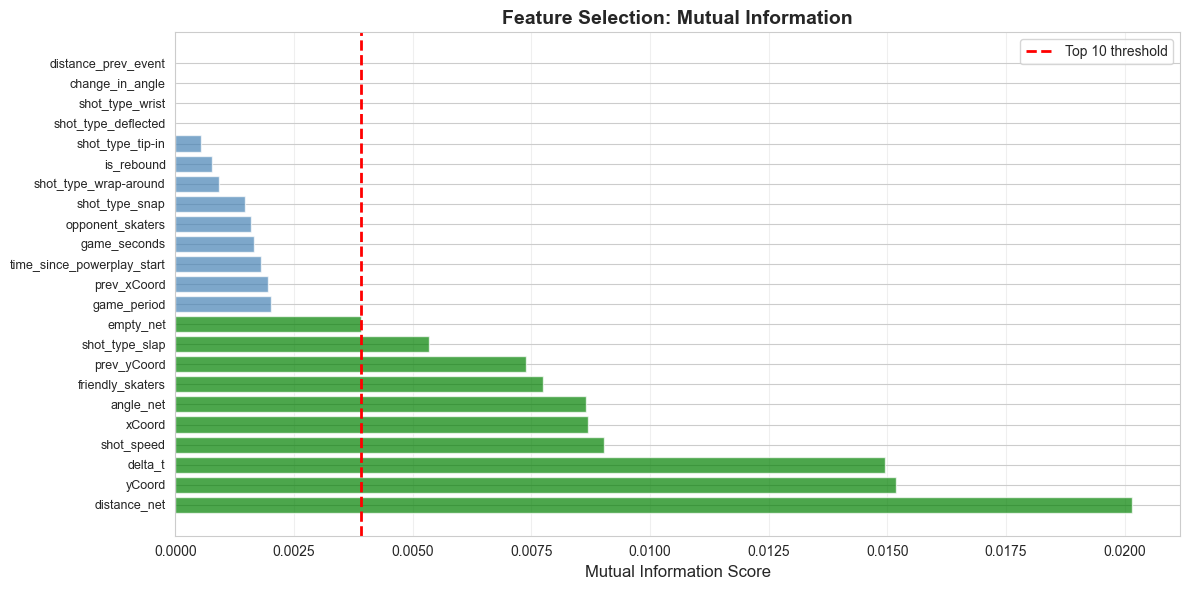

In [ ]:
# Comparaison détaillée
comparison_df, comparison_fig = compare_models_detailed(
    models_dict=models_dict,
    X_val=X_val,
    y_val=y_val,
    save_path=str(FIGURES_DIR / "models_comparison_detailed.png")
)

plt.show()

---
# Résumé des Fichiers Générés

## Modèles sauvegardés
- `models_saved/xgboost_baseline.pkl` + scaler (avec scale_pos_weight)
- `models_saved/xgboost_tuned.pkl` + scaler
- `models_saved/xgboost_feature_selected.pkl` + scaler

## Figures générées

### Question 1 - Baseline
- `q1_feature_importance_baseline.png`
- `q1_learning_curves_baseline.png`
- `q1_confusion_matrix_baseline.png` (Analyse déséquilibre)
- `q1_probability_distribution_baseline.png` (Distribution des probabilités)

### Question 2 - Modèle Optimisé
- `q2_feature_importance_tuned.png`
- `q2_threshold_analysis.png`
- `q2_confusion_matrix_tuned.png` (Analyse déséquilibre)
- `q2_probability_distribution_tuned.png` (Distribution des probabilités)

### Question 3 - Feature Selection
#### Méthodes d'Interprétabilité
- `q3_correlation_matrix.png`
- `shap_importance_bar.png`
- `shap_summary_beeswarm.png`
- `shap_dependence_plots.png`
- `shap_waterfall.png`
- `shap_force_plot.png`

#### Méthodes de Sélection (6 méthodes)
- `q3_rfe_analysis.png` (Wrapper: Recursive Feature Elimination)
- `q3_statistical_mutual_info.png` (Statistique: Mutual Information)
- `q3_sequential_forward.png` (Wrapper: Sequential Feature Selection)
- `q3_l1_regularization.png` (Embarquée: L1/Lasso)
- `q3_methods_comparison.png` (Comparaison globale des 6 méthodes)

### Figures d'évaluation (toutes questions)
- `xgboost_roc_curves.png`
- `xgboost_goal_rate_percentile.png`
- `xgboost_cumulative_goals.png`
- `xgboost_calibration_curves.png` (vérifie la calibration des probabilités)
- `models_comparison_detailed.png`

---

## Méthodes de Sélection de Features (6 méthodes couvrant 4 catégories)

### Méthodes Embarquées (Embedded)
- **Feature Importance XGBoost** - Utilise les importances natives du modèle
- **L1 Regularization (Lasso)** - Pénalité L1 pour forcer la sparsité

### Méthodes Wrapper
- **RFE (Recursive Feature Elimination)** - Élimination itérative avec cross-validation
- **Sequential Feature Selection** - Sélection forward/backward progressive

### Méthodes Statistiques
- **Mutual Information** - Mesure la dépendance entre features et target

### Méthodes d'Interprétabilité
- **SHAP (SHapley Additive exPlanations)** - Valeurs de Shapley pour l'importance

---
# Évaluation Finale sur les Données Test

## Objectif

Recharger les 3 modèles sauvegardés et les évaluer sur les données test (saison 2020-2021) pour obtenir les performances finales.

In [4]:
import joblib
import pickle

# Fonction pour recharger un modèle et son scaler
def load_model_and_scaler(model_path):
    """Charge un modèle XGBoost et son scaler associé."""
    print(f"Chargement de {model_path}...")
    
    # Essayer de charger le modèle (peut être un dict ou un objet direct)
    try:
        with open(model_path, 'rb') as f:
            loaded_data = pickle.load(f)
        
        # Si c'est un dictionnaire avec modèle et scaler
        if isinstance(loaded_data, dict):
            model = loaded_data['model']
            scaler = loaded_data['scaler']
            metadata = loaded_data.get('metadata', {})
        # Si c'est un modèle XGBoost direct 
        else:
            model = loaded_data
            # Charger le scaler séparé
            scaler_path = str(model_path).replace('.pkl', '_scaler.pkl')
            try:
                with open(scaler_path, 'rb') as f:
                    scaler = pickle.load(f)
            except FileNotFoundError:
                print(f"Scaler non trouvé à {scaler_path}")
                scaler = None
            metadata = {}
    except Exception as e:
        print(f"Erreur lors du chargement: {e}")
        raise
    
    print(f" Modèle chargé")
    if scaler is not None:
        print(f"Scaler chargé")
    
    # Extraire les features des métadonnées ou du modèle
    if 'features' in metadata:
        features = metadata['features']
        print(f" Features: {features[:3]}... ({len(features)} total)")
    else:
        # Essayer d'extraire du nom des features du modèle
        try:
            features = model.get_booster().feature_names
            print(f"  Features extraites du modèle: {features[:3]}... ({len(features)} total)")
            metadata['features'] = features
        except:
            print(f" Features non disponibles dans les métadonnées")
            features = None
            metadata['features'] = features
    
    return model, scaler, metadata

In [5]:
# Charger les 3 modèles
print("="*80)
print("CHARGEMENT DES MODÈLES SAUVEGARDÉS")
print("="*80)

model_baseline_loaded, scaler_baseline, metadata_baseline = load_model_and_scaler(
    MODELS_DIR / "xgboost_baseline.pkl"
)

model_tuned_loaded, scaler_tuned, metadata_tuned = load_model_and_scaler(
    MODELS_DIR / "xgboost_tuned.pkl"
)

model_fs_loaded, scaler_fs, metadata_fs = load_model_and_scaler(
    MODELS_DIR / "xgboost_feature_selected.pkl"
)

print("\n Tous les modèles ont été rechargés avec succès")

CHARGEMENT DES MODÈLES SAUVEGARDÉS
Chargement de d:\Bureau\project-datascience-python\models_saved\xgboost_baseline.pkl...
 Modèle chargé
Scaler chargé
  Features extraites du modèle: ['distance_net', 'angle_net']... (2 total)
Chargement de d:\Bureau\project-datascience-python\models_saved\xgboost_tuned.pkl...
 Modèle chargé
Scaler chargé
  Features extraites du modèle: ['xCoord', 'yCoord', 'distance_net']... (23 total)
Chargement de d:\Bureau\project-datascience-python\models_saved\xgboost_feature_selected.pkl...
 Modèle chargé
Scaler chargé
  Features extraites du modèle: ['distance_net', 'delta_t', 'angle_net']... (10 total)

 Tous les modèles ont été rechargés avec succès


In [7]:
# Importer apply_scaler si pas déjà fait
from ift6758.models.model_utils import apply_scaler

# Préparer les données test pour chaque modèle
print("="*80)
print("PREPARATION DES DONNEES TEST")
print("="*80)

# Baseline - distance + angle seulement
features_baseline = metadata_baseline['features']
X_test_baseline = X_test[features_baseline]
X_test_baseline_scaled = apply_scaler(X_test_baseline, scaler_baseline, fit=False)
print(f"\nBaseline: {len(features_baseline)} features")
print(f"  Shape: {X_test_baseline_scaled.shape}")

# Tuned - toutes les features
features_tuned = metadata_tuned['features']
X_test_tuned = X_test[features_tuned]
X_test_tuned_scaled = apply_scaler(X_test_tuned, scaler_tuned, fit=False)
print(f"\nTuned: {len(features_tuned)} features")
print(f"  Shape: {X_test_tuned_scaled.shape}")

# Feature Selected 
features_fs = metadata_fs['features']
X_test_fs = X_test[features_fs]
X_test_fs_scaled = apply_scaler(X_test_fs, scaler_fs, fit=False)
print(f"\nFeature Selected: {len(features_fs)} features")
print(f"  Shape: {X_test_fs_scaled.shape}")
print(f"  Features: {', '.join(features_fs)}")

PREPARATION DES DONNEES TEST

Baseline: 2 features
  Shape: (2022, 2)

Tuned: 23 features
  Shape: (2022, 23)

Feature Selected: 10 features
  Shape: (2022, 10)
  Features: distance_net, delta_t, angle_net, opponent_skaters, game_seconds, yCoord, shot_type_slap, shot_type_wrist, xCoord, time_since_powerplay_start


## Évaluation sur les Données Test

In [10]:
# Évaluer les 3 modèles sur les données test
print("="*80)
print("EVALUATION SUR LES DONNEES TEST")
print("="*80)

# 1. Baseline
print("1. XGBoost Baseline (distance + angle)")
baseline_test_metrics = evaluate_model(
    model_baseline_loaded,
    X_test_baseline_scaled,
    y_test,
    model_name="XGBoost Baseline - TEST"
)
print_metrics(baseline_test_metrics)
print("="*80)
# 2. Tuned 
print("2. XGBoost Tuned (all features)")
tuned_test_metrics = evaluate_model(
    model_tuned_loaded,
    X_test_tuned_scaled,
    y_test,
    model_name="XGBoost Tuned - TEST"
)
print_metrics(tuned_test_metrics)
print("="*80)

# 3. Feature Selected
print("3. XGBoost Feature Selected (10 features)")
fs_test_metrics = evaluate_model(
    model_fs_loaded,
    X_test_fs_scaled,
    y_test,
    model_name="XGBoost Feature Selected - TEST"
)
print_metrics(fs_test_metrics)
print("="*80)

EVALUATION SUR LES DONNEES TEST
1. XGBoost Baseline (distance + angle)

METRIQUES: XGBoost Baseline - TEST
  AUC-ROC:    0.6539
  Accuracy:   0.9050
  Precision:  0.0909
  Recall:     0.0055
  F1-Score:   0.0103
2. XGBoost Tuned (all features)

METRIQUES: XGBoost Tuned - TEST
  AUC-ROC:    0.6942
  Accuracy:   0.8447
  Precision:  0.2063
  Recall:     0.2514
  F1-Score:   0.2266


3. XGBoost Feature Selected (10 features)

METRIQUES: XGBoost Feature Selected - TEST
  AUC-ROC:    0.6926
  Accuracy:   0.8422
  Precision:  0.1937
  Recall:     0.2350
  F1-Score:   0.2123


In [11]:
# Tableau comparatif des résultats test
print("\n" + "="*80)
print("COMPARAISON DES PERFORMANCES SUR TEST")
print("="*80)

comparison_test = pd.DataFrame({
    'Modèle': ['Baseline', 'Tuned', 'Feature Selected'],
    'Features': [len(features_baseline), len(features_tuned), len(features_fs)],
    'Accuracy': [baseline_test_metrics['Accuracy'], tuned_test_metrics['Accuracy'], fs_test_metrics['Accuracy']],
    'Precision': [baseline_test_metrics['Precision'], tuned_test_metrics['Precision'], fs_test_metrics['Precision']],
    'Recall': [baseline_test_metrics['Recall'], tuned_test_metrics['Recall'], fs_test_metrics['Recall']],
    'F1': [baseline_test_metrics['F1'], tuned_test_metrics['F1'], fs_test_metrics['F1']],
    'AUC': [baseline_test_metrics['AUC'], tuned_test_metrics['AUC'], fs_test_metrics['AUC']]
})

print("\n", comparison_test.to_string(index=False))

# Meilleur modèle
best_model_idx = comparison_test['AUC'].idxmax()
best_model_name = comparison_test.loc[best_model_idx, 'Modèle']
best_model_auc = comparison_test.loc[best_model_idx, 'AUC']

print(f"\n Meilleur modèle: {best_model_name} (AUC = {best_model_auc:.4f})")

# Amélioration par rapport au baseline
for idx, row in comparison_test.iterrows():
    if idx > 0:  # Skip baseline
        improvement = (row['AUC'] - comparison_test.loc[0, 'AUC']) / comparison_test.loc[0, 'AUC'] * 100
        print(f"   {row['Modèle']}: +{improvement:.2f}% vs Baseline")


COMPARAISON DES PERFORMANCES SUR TEST

           Modèle  Features  Accuracy  Precision   Recall       F1      AUC
        Baseline         2  0.905045   0.090909 0.005464 0.010309 0.653907
           Tuned        23  0.844708   0.206278 0.251366 0.226601 0.694191
Feature Selected        10  0.842235   0.193694 0.234973 0.212346 0.692597

 Meilleur modèle: Tuned (AUC = 0.6942)
   Tuned: +6.16% vs Baseline
   Feature Selected: +5.92% vs Baseline


## Analyse des Matrices de Confusion sur Test

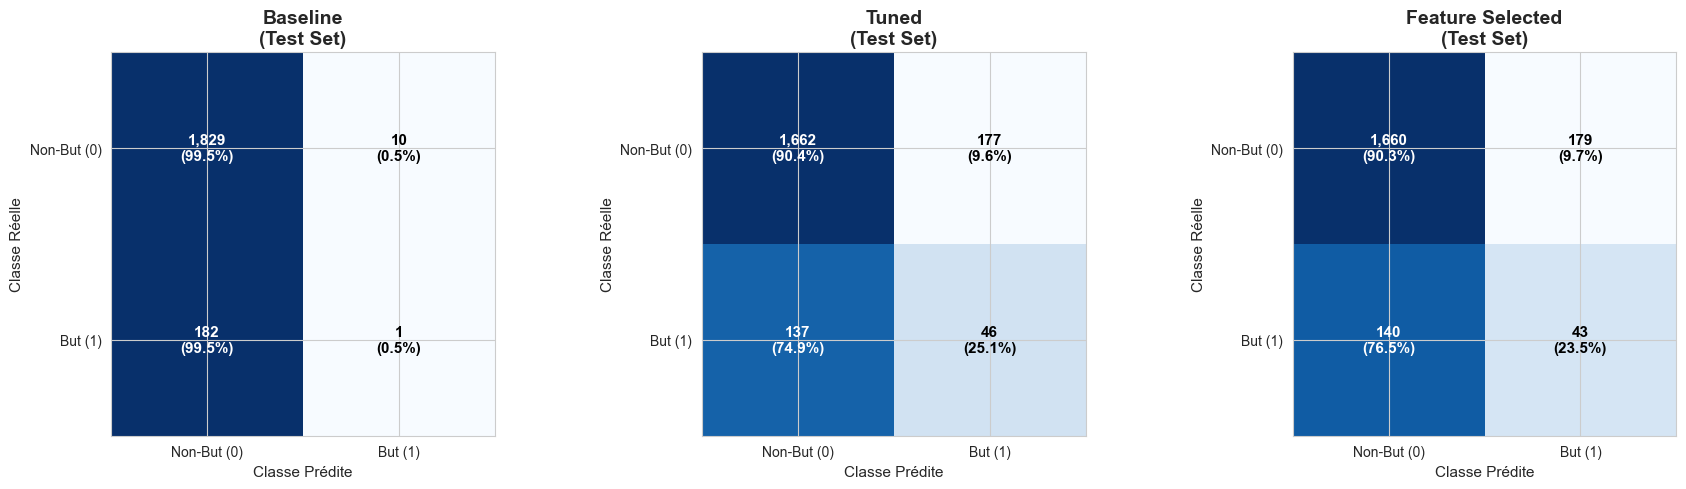

Matrices de confusion comparatives sauvegardées


In [13]:
# Matrices de confusion pour les 3 modèles sur TEST
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

models_info = [
    (model_baseline_loaded, X_test_baseline_scaled, "Baseline"),
    (model_tuned_loaded, X_test_tuned_scaled, "Tuned"),
    (model_fs_loaded, X_test_fs_scaled, "Feature Selected")
]

for idx, (model, X_test_scaled, name) in enumerate(models_info):
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
    y_pred = (y_pred_proba >= 0.5).astype(int)
    
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # Normaliser pour obtenir des pourcentages
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    
    # Afficher
    im = axes[idx].imshow(cm_percent, interpolation='nearest', cmap='Blues')
    axes[idx].set_title(f'{name}\n(Test Set)', fontsize=14, fontweight='bold')
    
    # Ajouter les valeurs
    for i in range(2):
        for j in range(2):
            text = axes[idx].text(j, i, f'{cm[i, j]:,}\n({cm_percent[i, j]:.1f}%)',
                                ha="center", va="center", color="white" if cm_percent[i, j] > 50 else "black",
                                fontsize=11, fontweight='bold')
    
    axes[idx].set_ylabel('Classe Réelle', fontsize=11)
    axes[idx].set_xlabel('Classe Prédite', fontsize=11)
    axes[idx].set_xticks([0, 1])
    axes[idx].set_yticks([0, 1])
    axes[idx].set_xticklabels(['Non-But (0)', 'But (1)'])
    axes[idx].set_yticklabels(['Non-But (0)', 'But (1)'])

plt.tight_layout()
plt.savefig(FIGURES_DIR / "confusion_matrices_test_comparison.png", dpi=150, bbox_inches='tight')
plt.show()

print("Matrices de confusion comparatives sauvegardées")

In [32]:
from combined_metric_curves import afficher_graphiques_metrics_comparatif

# Dictionnaire de modèles déjà entraînés
models_dict = {
    "XGBoost Baseline (distance + angle)": (model_baseline, BASIC_FEATURES),
    "XGBoost Tuned (all features)": (model_tuned, ALL_FEATURES),
    "XGBoost Feature Selected (10 features)": (model_fs, selected_features),
}

# appliquer les scalers correspondants à chaque modèle 
scalers_dict = {
    "XGBoost Baseline (distance + angle)": trainer_baseline.scaler,
    "XGBoost Tuned (all features)": trainer_tuned.scaler,
    "XGBoost Feature Selected (10 features)": trainer_fs.scaler,
}

fig, auc_scores = afficher_graphiques_metrics_comparatif(models_dict, X_val, y_val, scalers_dict)

print("\nAUC de chaque modèle :")
for name, auc in auc_scores.items():
    print(f"  - {name}: {auc:.3f}")

ModuleNotFoundError: No module named 'combined_metric_curves'